<a href="https://colab.research.google.com/github/MicroPyscho/MicroPyscho/blob/main/RF_Final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install tensorflow_addons
!pip install ranger-adabelief

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from torch import nn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
int_cols = pd.read_csv("/content/drive/MyDrive/int_cols.csv")

In [5]:
scaler = StandardScaler()
int_cols_scaled = pd.DataFrame(scaler.fit_transform(int_cols), columns=int_cols.columns)

#Apply log transformation if necessary
#Assuming the target column is 'total_emissns', let's check for skewness
target_col = 'total_emissns'
if np.abs(int_cols_scaled[target_col].skew()) > 0.5:
    int_cols_scaled[target_col] = np.log1p(int_cols_scaled[target_col])

# Split the data into features and target
X = int_cols_scaled.drop(columns=["total_emissns", "Emission_objtv", "emissn_score", "dirct_cemissions", "indirct_cemissions", "Grenhous_emissn", "CO2Emissn_%+-", "scope1", "scope2", "total_enrgy_use", "renwbl_enrgy_use", "envrmt_pilr_score", "Climate_incentive"])
y = int_cols_scaled["total_emissns"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


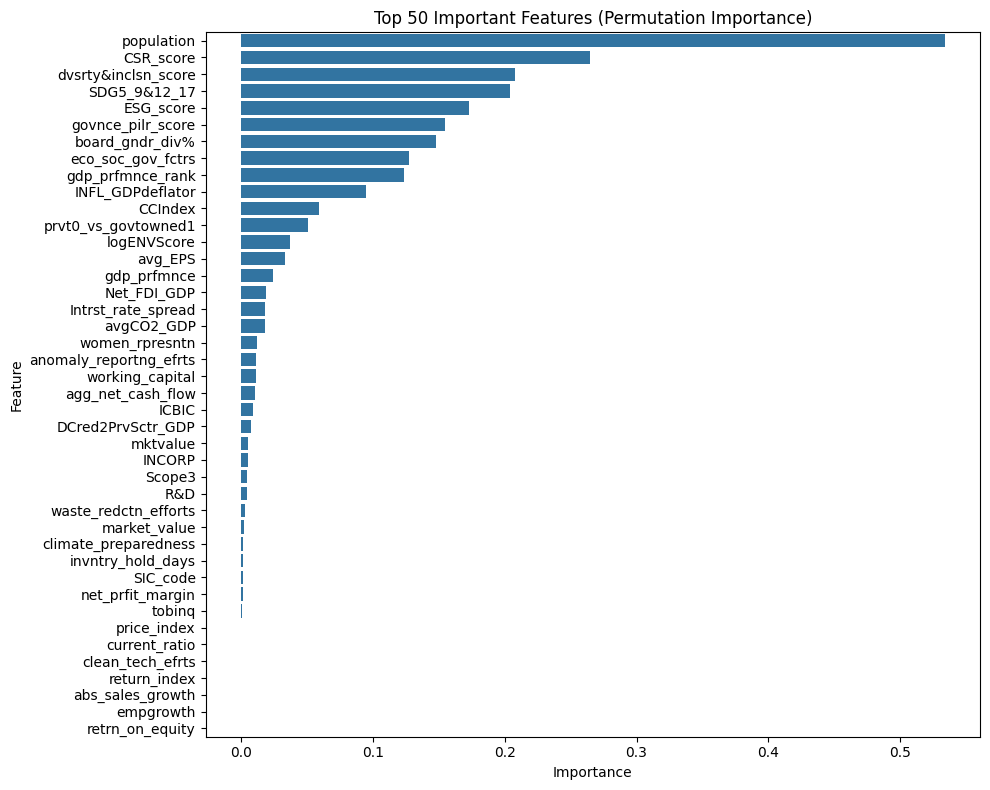

Model evaluation metrics for test data saved to Google Drive.
Model evaluation metrics for train data saved to Google Drive.
Top 50 feature importance plot saved to Google Drive.
Tabular comparison of actual and predicted values saved to Google Drive.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import randint
from sklearn.inspection import permutation_importance

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)

# Remove features with infinite VIF values or very high VIF values
high_vif_features = vif_data[vif_data['VIF'] > 20]['feature']
X = X.drop(columns=high_vif_features)

# Recalculate VIF after removal
vif_data = calculate_vif(X)
vif_data.to_csv('/content/drive/My Drive/vif_data_RF.csv', index=False)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and optimize the Random Forest model
rf = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Evaluate the model
best_rf = random_search.best_estimator_
y_pred_test = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

def evaluate_model(y_true, y_pred):
    return {
        'R2 Score': r2_score(y_true, y_pred),
        'Mean Squared Error': mean_squared_error(y_true, y_pred),
        'Root Mean Squared Error': np.sqrt(mean_squared_error(y_true, y_pred)),
        'Mean Absolute Error': mean_absolute_error(y_true, y_pred),
        'Explained Variance Score': explained_variance_score(y_true, y_pred)
    }

# Save evaluation metrics for test data
results_test = evaluate_model(y_test, y_pred_test)
results_df_test = pd.DataFrame([results_test])
results_df_test.to_csv('/content/drive/My Drive/evaluation_metrics_rf_test.csv', index=False)

# Save evaluation metrics for train data
results_train = evaluate_model(y_train, y_pred_train)
results_df_train = pd.DataFrame([results_train])
results_df_train.to_csv('/content/drive/My Drive/evaluation_metrics_rf_train.csv', index=False)

# Permutation importance
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-50:][::-1]

top_50_features = [(X.columns[i], perm_importance.importances_mean[i]) for i in sorted_idx]

top_50_df = pd.DataFrame(top_50_features, columns=['Feature', 'Importance'])
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_50_df)
plt.title('Top 50 Important Features (Permutation Importance)')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/top_50_features_rf.png')
plt.show()

# Create a tabular comparison of actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
comparison_df.to_csv('/content/drive/My Drive/actual_vs_predicted_rf.csv', index=False)

print(f'Model evaluation metrics for test data saved to Google Drive.')
print(f'Model evaluation metrics for train data saved to Google Drive.')
print(f'Top 50 feature importance plot saved to Google Drive.')
print(f'Tabular comparison of actual and predicted values saved to Google Drive.')


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


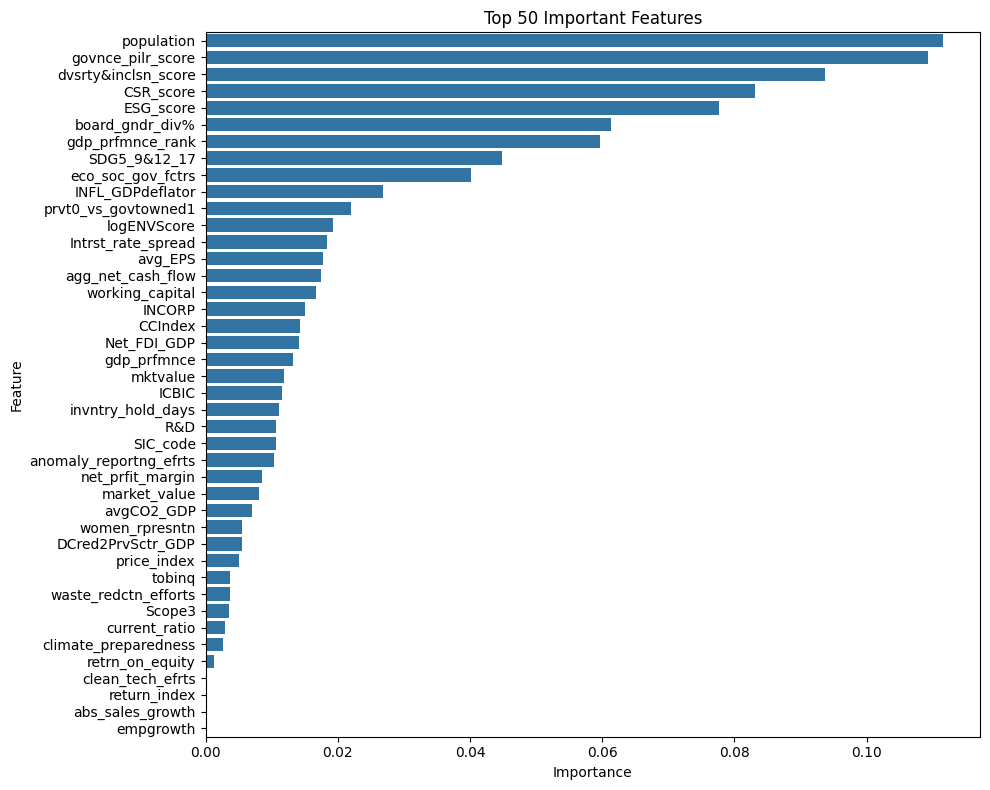

Model evaluation metrics saved to Google Drive.
Top 50 feature importance plot saved to Google Drive.
Tabular comparison of actual and predicted values saved to Google Drive.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import randint
from google.colab import drive

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)

# Remove features with infinite VIF values or very high VIF values
high_vif_features = vif_data[vif_data['VIF'] > 10]['feature']
X = X.drop(columns=high_vif_features)

# Recalculate VIF after removal
vif_data = calculate_vif(X)
vif_data.to_csv('/content/drive/My Drive/vif_data_RF.csv', index=False)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and optimize the Random Forest model
rf = RandomForestRegressor(random_state=42)
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Evaluate the model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    return {
        'R2 Score': r2_score(y_test, y_pred),
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'Explained Variance Score': explained_variance_score(y_test, y_pred)
    }

# Save evaluation metrics
results = evaluate_model(y_test, y_pred)
results_df = pd.DataFrame([results])
results_df.to_csv('/content/drive/My Drive/evaluation_metrics_rf.csv', index=False)

# Plot top 50 important features
feature_importances = best_rf.feature_importances_
top_50_idx = np.argsort(feature_importances)[-50:][::-1]
top_50_features = [(X.columns[i], feature_importances[i]) for i in top_50_idx]

top_50_df = pd.DataFrame(top_50_features, columns=['Feature', 'Importance'])
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_50_df)
plt.title('Top 50 Important Features')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/top_50_features_rf.png')
plt.show()

# Create a tabular comparison of actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df.to_csv('/content/drive/My Drive/actual_vs_predicted_rf.csv', index=False)

print(f'Model evaluation metrics saved to Google Drive.')
print(f'Top 50 feature importance plot saved to Google Drive.')
print(f'Tabular comparison of actual and predicted values saved to Google Drive.')


In [7]:
display(comparison_df.head())
display(results_df)

,Actual,Predicted
23139,-0.341899,-0.319412
32340,1.047290,1.003355
42613,-0.303026,-0.243764
81545,-0.018267,-0.246130
13436,-0.343624,-0.141815


,R2 Score,Mean Squared Error,Mean Absolute Error,Explained Variance Score
0,0.703241,0.047601,0.111977,0.703244
